In [1]:
import os

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import udf

from graphframes import *
import hashlib

# Detect Communities with Label Propagation

There are many community detection techniques, I focus only on one: label propagation.
1. At the beginning, each node starts in its own community.
2. For each iteration, go through all your nodes randomly. For each node, update that node’s community label with the label of the majority of its neighbors. Randomly break any ties.
3. If nodes are now labelled with the majority label of their neighbors, the algorithm has achieved the stop criterion. If not, repeat step 2.

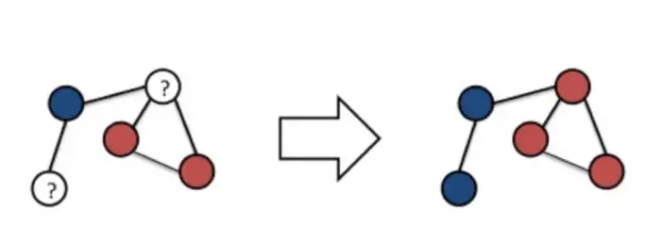

# Dataset : Common Crawl Dataset

The Common Crawl corpus contains petabytes of data collected since 2008. It contains raw web page data, extracted metadata and text extractions. (In addition to page contents, the dataset contains crawl date, headers used, and other metadata.)

I am using the preprocessed version of the dataset from https://towardsdatascience.com/large-scale-graph-mining-with-spark-part-2-2c3d9ed15bb5
1.  For each page, they collect the URL and the URLs of any links to create the graph.
2. drew edges between domains rather than full URLs.
3. filtered out loops. Loops are edges that connect a node to itself, not useful for my purposes.
4. removed many of the most popular resource links, including popular CDNs, trackers, and assets.

In [3]:
spark = SparkSession.builder.appName('notebook').getOrCreate()

# Load sample webgraph


In [4]:
raw_data = spark.read.parquet("part-00000-56b6fa02-69f2-490c-95dd-bec919d21571-c000.snappy.parquet")
raw_data.count()


18399

Rename columns to something decent. 

In [6]:
df = raw_data.withColumnRenamed("_c0", "parent")\
.withColumnRenamed("_c1", "parentTLD")\
.withColumnRenamed("_c2", "childTLD")\
.withColumnRenamed("_c3", "child")\
.filter("parentTLD is not null and childTLD is not null")

In [8]:
df.show(10)

+--------------+---------+----------------+--------------------+
|        parent|parentTLD|        childTLD|               child|
+--------------+---------+----------------+--------------------+
|http://msn.com|  msn.com|tradedoubler.com|https://clk.trade...|
|http://msn.com|  msn.com|   microsoft.com|https://go.micros...|
|http://msn.com|  msn.com|     outlook.com|http://www.outloo...|
|http://msn.com|  msn.com|   microsoft.com|https://advertisi...|
|http://msn.com|  msn.com|tradedoubler.com|https://clk.trade...|
|http://msn.com|  msn.com|        bing.com|//www.bing.com/se...|
|http://msn.com|  msn.com|tradedoubler.com|https://clk.trade...|
|http://msn.com|  msn.com|   qualtrics.com|https://jfe.qualt...|
|http://msn.com|  msn.com|tradedoubler.com|https://clk.trade...|
|http://msn.com|  msn.com|        bing.com|//www.bing.com/se...|
+--------------+---------+----------------+--------------------+
only showing top 10 rows



Select set of parents and children TLDs (your nodes) to assign id for each node.

In [11]:
aggcodes = df.select("parentTLD","childTLD").rdd.flatMap(lambda x: x).distinct()
aggcodes.count()

4613

In [12]:
def hashnode(x):
    return hashlib.sha1(x.encode("UTF-8")).hexdigest()[:8]

hashnode_udf = udf(hashnode)

vertices contains an idfor each node, and the name of the node, which indicates the domain.

In [13]:
vertices = aggcodes.map(lambda x: (hashnode(x), x)).toDF(["id","name"])
vertices.show(10)

+--------+----------------+
|      id|            name|
+--------+----------------+
|000db143|         msn.com|
|51a48ea2|tradedoubler.com|
|31312317|   microsoft.com|
|a45016f2|     outlook.com|
|2f5bf4c8|        bing.com|
|1a68d147|   qualtrics.com|
|2c999707|     yahoo.co.jp|
|94adae10|   yahoo-help.jp|
|3e2824e8|       lohaco.jp|
|34bac370|        yahoo.jp|
+--------+----------------+
only showing top 10 rows



edges contains my directed edges, from source domain src to the domain the source links to, dst.

In [16]:
edges = df.select("parentTLD","childTLD")\
.withColumn("src", hashnode_udf("parentTLD"))\
.withColumn("dst", hashnode_udf("childTLD"))\
.select("src","dst")

edges.count()

18398

In [17]:
edges.show(10)

+--------+--------+
|     src|     dst|
+--------+--------+
|000db143|51a48ea2|
|000db143|31312317|
|000db143|a45016f2|
|000db143|31312317|
|000db143|51a48ea2|
|000db143|2f5bf4c8|
|000db143|51a48ea2|
|000db143|1a68d147|
|000db143|51a48ea2|
|000db143|2f5bf4c8|
+--------+--------+
only showing top 10 rows



In [18]:
graph = GraphFrame(vertices, edges)
graph

C:\Spark\spark\python\pyspark\sql\dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


GraphFrame(v:[id: string, name: string], e:[src: string, dst: string])

# Label Propagation Algorithm

In [19]:
communities = graph.labelPropagation(maxIter=5)
communities.persist().show(10)

C:\Spark\spark\python\pyspark\sql\dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------+--------------------+-------------+
|      id|                name|        label|
+--------+--------------------+-------------+
|407ae1cc|             coop.no| 781684047881|
|1b0357be|  buenacuerdo.com.ar|1245540515843|
|acc8136a|   toptenreviews.com|1537598291986|
|abdd63cd| liberoquotidiano.it| 317827579915|
|db5c0434|          meetme.com|1073741824010|
|0f8dff85|           ameblo.jp| 171798691842|
|b6b04a58|             tlnk.io|1632087572480|
|5bcfd421|         wowhead.com| 429496729618|
|b4d4008d|investingcontrari...| 919123001350|
|ce7a3185|   pokemoncentral.it|1511828488194|
+--------+--------------------+-------------+
only showing top 10 rows



In [21]:
print (f"There are {communities.select('label').distinct().count()} communities in sample graph.")


There are 630 communities in sample graph.


Running graph.labelPropagation() returns a DataFrame with nodes and a label denoting which community that node belongs in. You can use label to understand distribution of community size and zoom in on areas of interest. For example, to discover every other website in the same community as pokemoncentral.it (and honestly, who wouldn’t?), filter for all other nodes where label = 1511828488194.

In [25]:
communities.filter("label = 781684047881").show()

+--------+----------------+------------+
|      id|            name|       label|
+--------+----------------+------------+
|407ae1cc|         coop.no|781684047881|
|ba4ba6eb|        storm.no|781684047881|
|66920ba4|medietilsynet.no|781684047881|
|04452b92|  publishlab.com|781684047881|
|2abb6128|  tv2-fotball.no|781684047881|
+--------+----------------+------------+



# Degrees and PageRank


Count nodes by number of in-degrees


In [20]:
graph.inDegrees.join(vertices, on="id")\
.orderBy("inDegree", ascending=False).show(10)

+--------+--------+-------------+
|      id|inDegree|         name|
+--------+--------+-------------+
|465806fb|    1223|  twitter.com|
|b7c70898|    1154| facebook.com|
|baea954b|     584|   google.com|
|d84f4904|     374|pinterest.com|
|366b6783|     358|       sky.it|
|06252e37|     295|instagram.com|
|d7e222c8|     266|  youtube.com|
|1a8028a6|     172|        po.st|
|cd0cf82b|     167|    zoznam.sk|
|de740f90|     148|    apple.com|
+--------+--------+-------------+
only showing top 10 rows



Run PageRank

In [22]:
results = graph.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank")\
.join(vertices, on="id").orderBy("pagerank", ascending=False)\
.show(10)

+--------+------------------+-------------+
|      id|          pagerank|         name|
+--------+------------------+-------------+
|15a17dcc| 72.02193053242661|messenger.com|
|b7c70898| 71.82925336390569| facebook.com|
|465806fb| 62.38821611443578|  twitter.com|
|d7e222c8| 47.78395449650086|  youtube.com|
|baea954b|29.768891546015652|   google.com|
|06252e37|21.365246391507494|instagram.com|
|d84f4904|13.619116925738885|pinterest.com|
|de740f90|10.538651654351058|    apple.com|
|1b274516| 4.731072973007598| linkedin.com|
|f0a549e2|4.4062056573357875|        ds.tl|
+--------+------------------+-------------+
only showing top 10 rows

